# Fake news analysis and prediction



---




Project by Luis Alcalá Pérez

# Dataset information

This dataset contains 2 csv files, containing real and fake articles.


*   fake.csv (59.88 Mb)
*   True.csv (51.1 Mb)

Each of this files contains 4 features:


*   Title of the article
*   Text of the article
*   Subject of the article
*   Publish date


#Libraries

In [ ]:
import os
import re
import nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
import spacy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from numpy.random import seed
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder as le
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import  RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from google.colab import drive
from bs4 import BeautifulSoup
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import LdaMulticore

import warnings
warnings.filterwarnings("ignore")

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
!python -m spacy download en_vectors_web_lg
!python -m spacy link en_vectors_web_lg en_vectors_web_lg_link

     |████████████████████████████████| 661.8MB 1.7MB/s 
  Created wheel for en-vectors-web-lg: filename=en_vectors_web_lg-2.1.0-cp37-none-any.whl size=663461747 sha256=6468b1211c1420799160016325154d924df8efccb3975d8c40d5efa045c74f20
  Stored in directory: /tmp/pip-ephem-wheel-cache-bt1spe6x/wheels/ce/3e/83/59647d0b4584003cce18fb68ecda2866e7c7b2722c3ecaddaf
Successfully built en-vectors-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_vectors_web_lg')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_vectors_web_lg -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en_vectors_web_lg_link
You can now load the model via spacy.load('en_vectors_web_lg_link')


# Loading the dataset


*   Loading the data from the csv files
*   Mixing both datasets randomly
*   Analyse the data available

In [ ]:
# Loading the True dataset
data_true = pd.read_csv('True.csv')
data_true['class'] = 'True'  # Assign the True label

# Loading the Fake dataset
data_fake = pd.read_csv('Fake.csv')
data_fake['class'] = 'Fake'  # Assign the Fake label

# We mix both datasets randomly and add a index
data = data_true.append(data_fake).sample(frac = 1, random_state = 1)
data.index = range(len(data_true) + len(data_fake))

In [ ]:
# Count how many datasets of fake and true news
print("------- Articles count ---------")
print(str(data['class'].value_counts()))
print("--------------------------------")

data.head(10)

------- Articles count ---------
Fake    23481
True    21417
Name: class, dtype: int64
--------------------------------


,title,text,subject,date,class
0,EPA chief says Paris climate agreement 'bad de...,WASHINGTON (Reuters) - The United States shoul...,politicsNews,"April 2, 2017",True
1,BREAKING NEWS: President Trump Announces Major...,President Trump just tweeted out a new policy ...,politics,"Jul 26, 2017",Fake
2,Trump says New Hampshire win not necessary to ...,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,"February 7, 2016",True
3,Kremlin: U.S. sanctions aimed at turning busin...,MOSCOW (Reuters) - The Kremlin said on Thursda...,worldnews,"November 30, 2017",True
4,MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...,Kellyanne Conway s response to Williams criti...,left-news,"Dec 27, 2016",Fake
5,Poland's PM designate says will continue fight...,WARSAW (Reuters) - Poland will continue fighti...,worldnews,"December 8, 2017",True
6,One more Republican defection would doom Senat...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"July 14, 2017",True
7,IT BEGINS: ANTHONY SCARAMUCCI FIRES Suspected ...,Scaramucci promised the heads of White House l...,politics,"Jul 25, 2017",Fake
8,Refugee Living In England Arrested For Threate...,"Here is just one more, in a long line of stori...",left-news,"Jan 27, 2016",Fake
9,"Cory Booker EVISCERATES RNC’s Hateful Tone, ‘...",Senator Cory Booker was none too happy with wh...,News,"July 23, 2016",Fake


In [ ]:
# count how many samples of each subject are in each class
counts = pd.DataFrame(data[['subject', 'class']].value_counts(), columns = ['count'])
counts

,,count
subject,class,
politicsNews,True,11272
worldnews,True,10145
News,Fake,9050
politics,Fake,6841
left-news,Fake,4459
Government News,Fake,1570
US_News,Fake,783
Middle-east,Fake,778


Let's analyse if there is any name of media that has published the articles in the text. If we look closely, we can see that the name of media appears, when it exists, between brakets at the start of the text. Therefore, we can, with the Regular Expressions library, check for those name of media. 

In [ ]:
# Let's define a function to search for the name of the media
def media_search(text):
    text = re.findall(r'(?<= \()\w+(?=\) - )', text[:200])  # we search at the 200 first characters of the string
    # if we find anything we return it, if not we return 'not available'
    if text:
        return text[0]   
    else:
        return 'Not available'

# Apply the function to the text we have
data['Media'] = data['text'].apply(media_search)

# Let's count the results obtained by Fake and Real news
media_counts = pd.DataFrame(data[['Media', 'class']].value_counts(), columns = ['count'])
media_counts

,,count
Media,class,
Not available,Fake,23481
Reuters,True,19741
Not available,True,1673
IFR,True,3


# Text preparation

## Media and tweet info

First, we need to solve the problem with the media names. As we have seen, most of text from real news contains media information such as "WASHINGTON (Reuters). This needs to be separated from the actual text. If we analyse the text, we can see that the media information is always separated from the actual text by a '-'. Therefore, we can easily separte media info from text.

Furthermore, some news come from tweets, for the sake of this project, we are going to delete those news. Tweets have always a length as max as 259 characters. 

In [ ]:
# Let's create a list with the news that have no information about the media

no_media = []
for ind,string in enumerate(data.text.values):
    try:
        record = string.split(" -", maxsplit=1)
        record[1] # if no text part is present -> error
        # if lenght of the text is bigger than 260 -> error
        assert(len(record[0]) < 260)  # we check if the the text is a tweet
    except:
        no_media.append(ind)

In [ ]:
# we can see here a few news that, in fact, have no information about the media
data.iloc[no_media].text

1        President Trump just tweeted out a new policy ...
4        Kellyanne Conway s response to Williams  criti...
7        Scaramucci promised the heads of White House l...
8        Here is just one more, in a long line of stori...
9        Senator Cory Booker was none too happy with wh...
                               ...                        
44890    Thank you to the American Mirror for putting t...
44891    Alabama is a notoriously deep red state. It s ...
44893    This year, let s try something a little differ...
44894    Yes, the Democrats think it s a good thing to ...
44897    .@Nigel_Farage tells the #CPAC2017 crowd his f...
Name: text, Length: 23445, dtype: object

In [ ]:
# Let's separate the media info form the actual text
media = []  # were we are going to append the media of each new
media_free_text = []  # were we are going to append the text withour the medua info

for ind,row in enumerate(data.text.values):
    # if the new has no media, we save it and tag it with unknown 
    if ind in no_media:
        media_free_text.append(row)  
        media.append("Unknown")
        continue
    # if it has a media, we split both infos and save them separetely
    text_split = row.split(" -", maxsplit=1)
    media.append(text_split[0])
    media_free_text.append(text_split[1])


In [ ]:
# Now we just create a new column in the dataset with the media info
# and we replace the original text with the one with no media info
data['Media'] = media
data['text'] = media_free_text
data.head(10)

,title,text,subject,date,class,Media
0,EPA chief says Paris climate agreement 'bad de...,The United States should continue to be “enga...,politicsNews,"April 2, 2017",True,WASHINGTON (Reuters)
1,BREAKING NEWS: President Trump Announces Major...,President Trump just tweeted out a new policy ...,politics,"Jul 26, 2017",Fake,Unknown
2,Trump says New Hampshire win not necessary to ...,U.S. Republican presidential candidate Donald...,politicsNews,"February 7, 2016",True,WASHINGTON (Reuters)
3,Kremlin: U.S. sanctions aimed at turning busin...,The Kremlin said on Thursday it was confident...,worldnews,"November 30, 2017",True,MOSCOW (Reuters)
4,MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...,Kellyanne Conway s response to Williams criti...,left-news,"Dec 27, 2016",Fake,Unknown
5,Poland's PM designate says will continue fight...,"Poland will continue fighting tax evasion, al...",worldnews,"December 8, 2017",True,WARSAW (Reuters)
6,One more Republican defection would doom Senat...,President Donald Trump turned up the heat on ...,politicsNews,"July 14, 2017",True,WASHINGTON (Reuters)
7,IT BEGINS: ANTHONY SCARAMUCCI FIRES Suspected ...,Scaramucci promised the heads of White House l...,politics,"Jul 25, 2017",Fake,Unknown
8,Refugee Living In England Arrested For Threate...,"Here is just one more, in a long line of stori...",left-news,"Jan 27, 2016",Fake,Unknown
9,"Cory Booker EVISCERATES RNC’s Hateful Tone, ‘...",Senator Cory Booker was none too happy with wh...,News,"July 23, 2016",Fake,Unknown


## Missing data

Once we have taked care of the above problem, let's check if we have any missing data, just in case. 

In [ ]:
# Check for empty texts
nan_text_data = [index for index,text in enumerate(data.text.values) if str(text).strip() == '']
len(nan_text_data)

631

In [ ]:
data.iloc[nan_text_data].head()

,title,text,subject,date,class,Media
76,PRESIDENT-ELECT TRUMP Works As A Waiter At His...,,politics,"Nov 26, 2016",Fake,Unknown
149,NANCY PELOSI ASKED: Who’s the Leader of the De...,,politics,"Mar 22, 2017",Fake,Unknown
162,DEMOCRAT ALAN DERSHOWITZ Calls Out Court’s Rul...,,politics,"Mar 20, 2017",Fake,Unknown
188,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016",True,Unknown
217,PHONY HILLARY PULLS THE WOMAN CARD AT JAY-Z/BE...,,left-news,"Nov 5, 2016",Fake,Unknown


In [ ]:
# Check for empty titles
nan_title_data = [index for index,title in enumerate(data.title.values) if str(title).strip() == '']
len(nan_title_data)

0

As we can see, we have 631 articles with empty text. We are going to delete these news. 

In [ ]:
data.drop(nan_text_data)

,title,text,subject,date,class,Media
0,EPA chief says Paris climate agreement 'bad de...,The United States should continue to be “enga...,politicsNews,"April 2, 2017",True,WASHINGTON (Reuters)
1,BREAKING NEWS: President Trump Announces Major...,President Trump just tweeted out a new policy ...,politics,"Jul 26, 2017",Fake,Unknown
2,Trump says New Hampshire win not necessary to ...,U.S. Republican presidential candidate Donald...,politicsNews,"February 7, 2016",True,WASHINGTON (Reuters)
3,Kremlin: U.S. sanctions aimed at turning busin...,The Kremlin said on Thursday it was confident...,worldnews,"November 30, 2017",True,MOSCOW (Reuters)
4,MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...,Kellyanne Conway s response to Williams criti...,left-news,"Dec 27, 2016",Fake,Unknown
...,...,...,...,...,...,...
44893,THIS YEAR: Let’s Make Christmas Great Again…,"This year, let s try something a little differ...",US_News,"December 25, 2016",Fake,Unknown
44894,DEMOCRATS SELL Promo T-Shirt: “Democrats give ...,"Yes, the Democrats think it s a good thing to ...",politics,"Apr 20, 2017",Fake,Unknown
44895,White House aides told to preserve materials i...,The White House counsel’s office has sent a m...,politicsNews,"March 2, 2017",True,WASHINGTON (Reuters)
44896,'Congratulations': EU moves to Brexit phase tw...,The European Union agreed on Friday to move B...,worldnews,"December 15, 2017",True,BRUSSELS (Reuters)


Now we are ready to process the data.

## Text preprocessing

We are going to implement some functions to clean the data. To do so we use the *BeatifulSoup* and *Regular Expressions* libraries.


*   del_html() : remove any html code that might be in the text
*   del_punctuations() : delete the punctuations 
*   del_characters() : delete special characters
*   del_stopwords_lemma() : delete stopwords from the nltk english library and lemmantize
*   processing() : apply all the preprocessing functions  

In [ ]:
# HTML parser
def del_html(text):
    soup = BeautifulSoup(text, "html.parser")
    final_text = soup.get_text()
    return final_text

# Delete Punctuation
def del_punctuations(text):
    # deletion of all the punctuations
    final_text = re.sub('\[[^]]*\]', '', text)
    return final_text

# Delete Special characters
def del_characters(text):
    # substitution of everything that are not letters by a space
    final_text = re.sub("[^a-zA-Z]"," ",text)
    return final_text

# Delete stopwords and lemmantization
# We use the english stopwords from the nltk library
def del_stopwords_lemma(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)

    final_text = " ".join(final_text)
    return final_text

# We apply all the preprocessing to the text in order
def processing(text):
    text = del_html(text)
    text = del_punctuations(text)
    text = del_characters(text)
    text = del_stopwords_lemma(text)
    return text

In [ ]:
# We call the above functions on our data
# Processing on the whole text
texts = data
texts['text'] = texts['text'].apply(processing)

In [ ]:
# Processing on the title
texts['title'] = texts['title'].apply(processing)

In [ ]:
# To do so, we are going to join the text and the title
# as our text data for each document
# We dont use the subject feature beacause it's not the same in real
# and fake data
texts['text'] = texts['title'] + " " + texts['text']
del texts['subject']
texts.head()

,title,text,date,class,Media
0,epa chief say paris climate agreement bad deal u,epa chief say paris climate agreement bad deal...,"April 2, 2017",True,WASHINGTON (Reuters)
1,breaking news president trump announces major ...,breaking news president trump announces major ...,"Jul 26, 2017",Fake,Unknown
2,trump say new hampshire win necessary secure n...,trump say new hampshire win necessary secure n...,"February 7, 2016",True,WASHINGTON (Reuters)
3,kremlin u sanction aimed turning business elit...,kremlin u sanction aimed turning business elit...,"November 30, 2017",True,MOSCOW (Reuters)
4,must watch kellyanne conway punch back juan wi...,must watch kellyanne conway punch back juan wi...,"Dec 27, 2016",Fake,Unknown


# Some exploration on the clean data

Now that we have our texts preprocessed, let's analyse a bit how the data is. 

## Lengths

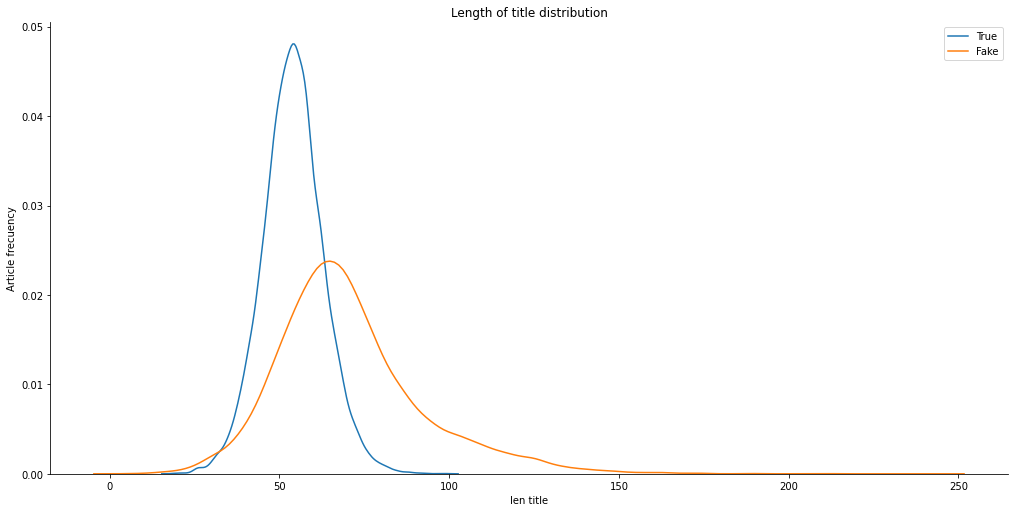

In [ ]:
# Let's compare the length of the titles fake vs real
# We compute the length of the title
data['len title'] = texts['title'].apply(len)

g = sns.FacetGrid(data, hue='class', height = 8, aspect = 2)
g.map(sns.kdeplot, 'len title')
plt.title('Length of title distribution')
plt.legend()
plt.ylabel('Article frecuency')
plt.show()

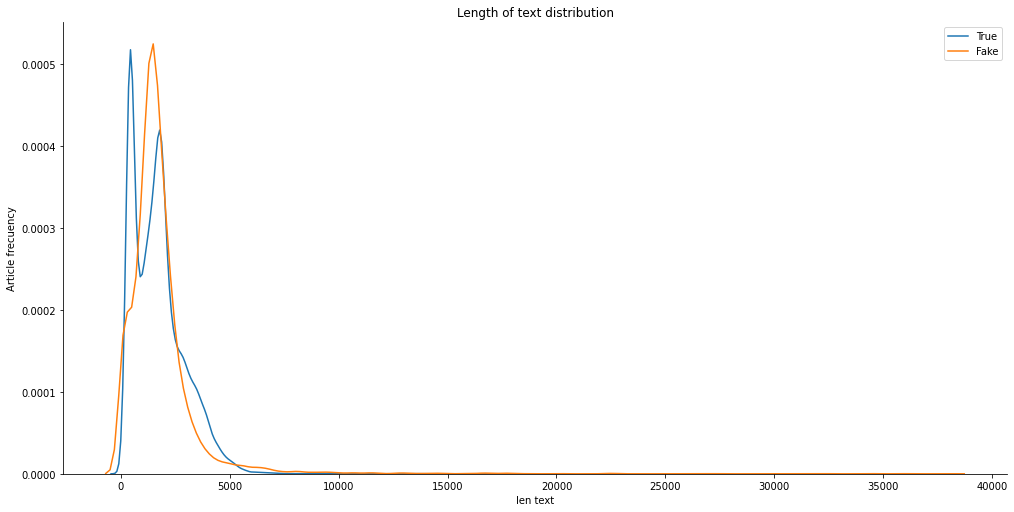

In [ ]:
# Lets first analyse the lenght of the texts
data['len text'] = texts['text'].apply(len)

g = sns.FacetGrid(data, hue='class', height = 8, aspect = 2)
g.map(sns.kdeplot, 'len text')
plt.title('Length of text distribution')
plt.legend()
plt.ylabel('Article frecuency')
plt.show()

## Wordclouds

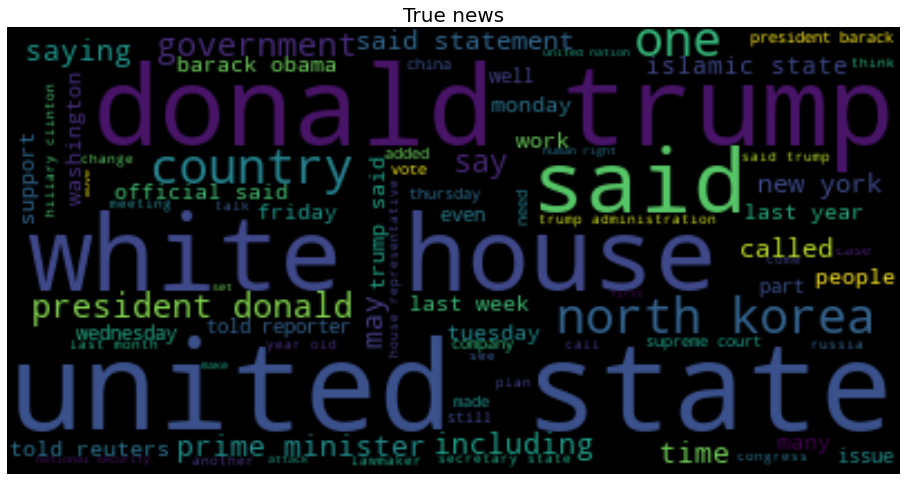

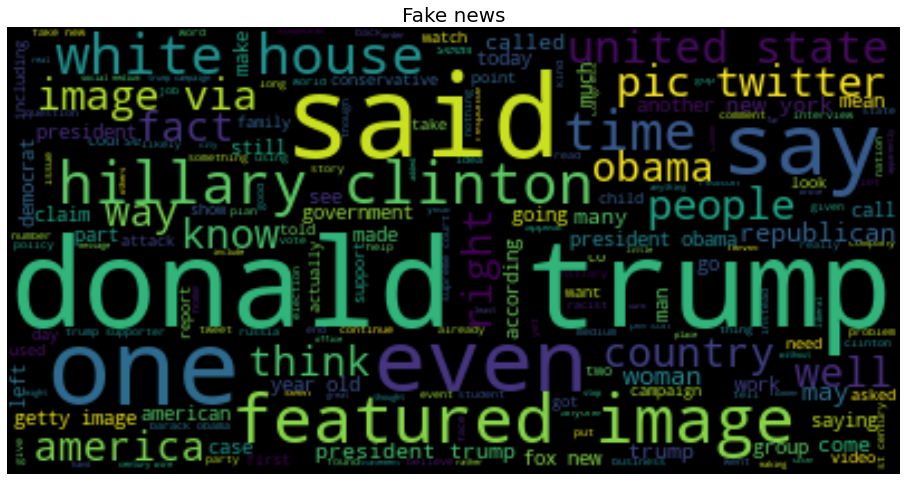

In [ ]:
# Let's generate a wordcloud for real and for fake news
# Define a function to get the right text for the wordcloud
def text_wordcloud(label):
    text = ' '.join(texts['text'][texts['class'] == label].to_list())
    return text

# We plot both wordclouds
for label in ['True', 'Fake']:
    wordcloud = WordCloud(
        max_font_size=500,
        max_words=500,
    ).generate(text_wordcloud(label))

    plt.figure(figsize=(16, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'{label} news', fontsize=20)
    plt.show()

## N-grams

In [ ]:
# We first adapt the text splitting it into words
string_pre = ' '.join(texts['text'])
string = string_pre.split(" ")

In [ ]:
# We define a function to compute the n-gram and plot it
def n_grams(string,n,values=15):
    n_gram = (pd.Series(nltk.ngrams(string, n)).value_counts())[:values]
    n_gram_data = pd.DataFrame(n_gram)
    n_gram_data = n_gram_data.reset_index()
    n_gram_data = n_gram_data.rename(columns={"index": "words", 0: "counts"})
    plt.figure(figsize = (15,8))
    sns.barplot(x='counts',y='words', data=n_gram_data)
    plt.show()

### 1-gram

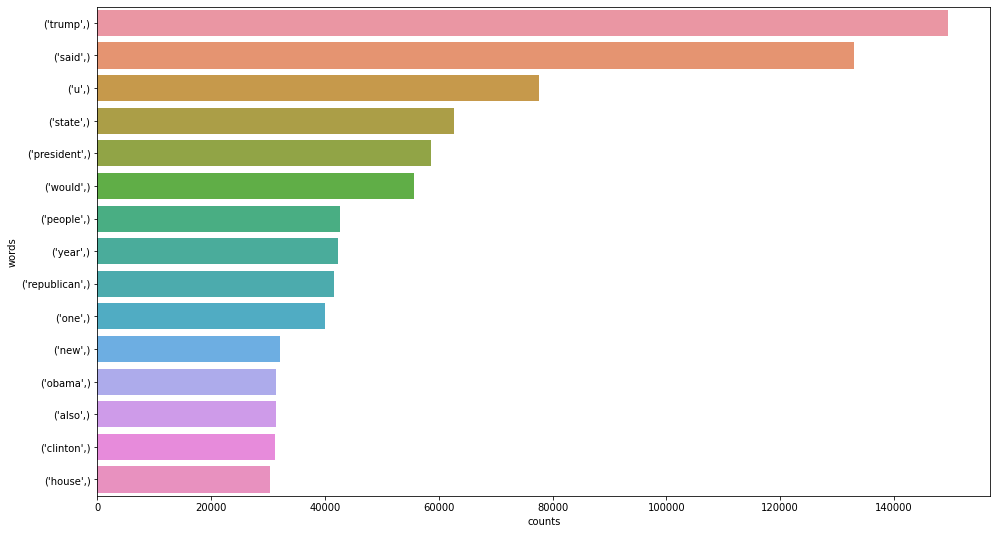

In [ ]:
n_grams(string,1)

### 2-gram

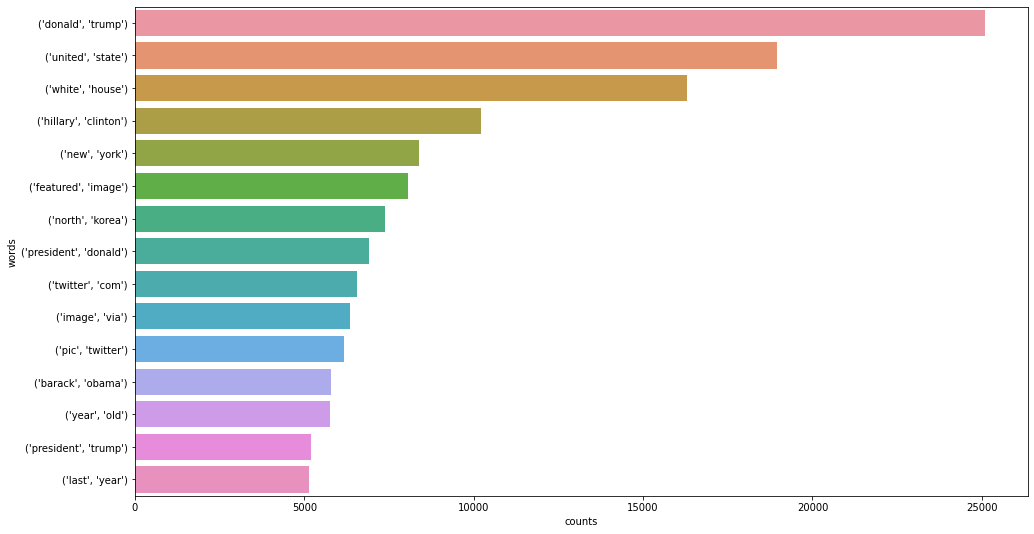

In [ ]:
n_grams(string,2)

### 3-gram

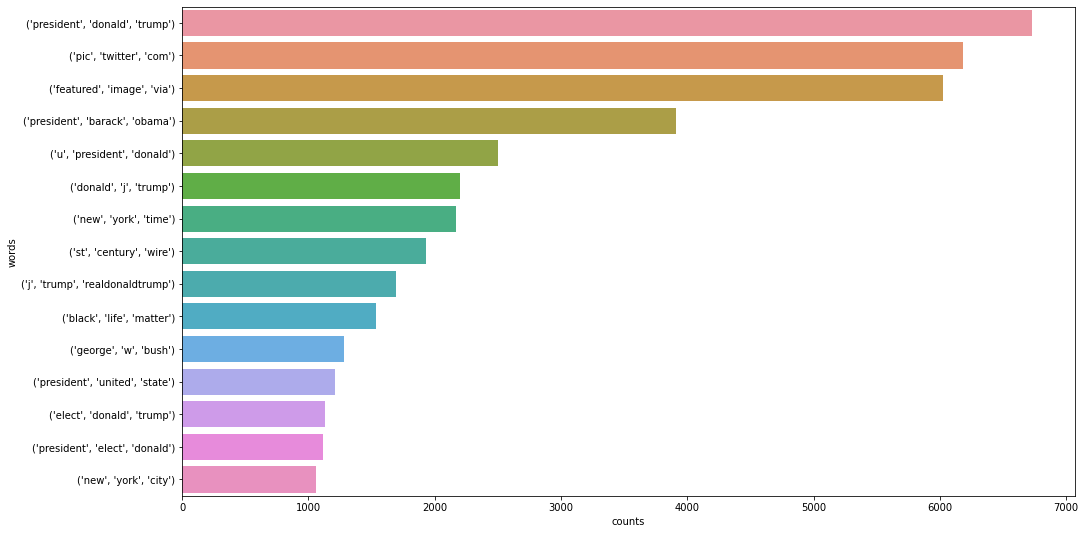

In [ ]:
n_grams(string,3)

## Sentiment analysis

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
# Let's perform some sentiment analysis on the titles and the text
# title
sia_title = pd.DataFrame([sia.polarity_scores(title) for title in texts['title']])
sia_title['class'] = texts['class']
# text
sia_text = pd.DataFrame([sia.polarity_scores(text) for text in texts['text']])
sia_text['class'] = texts['class']

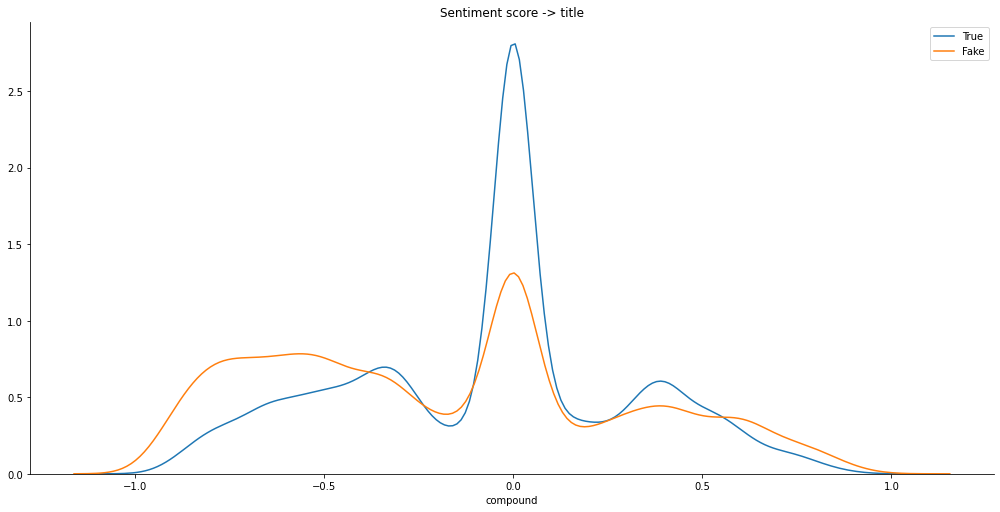

In [ ]:
# Ploting the results (title)
g = sns.FacetGrid(sia_title, hue='class', height = 7, aspect = 2)
g.map(sns.kdeplot, 'compound')
plt.title('Sentiment score -> title')
plt.legend()
plt.show()

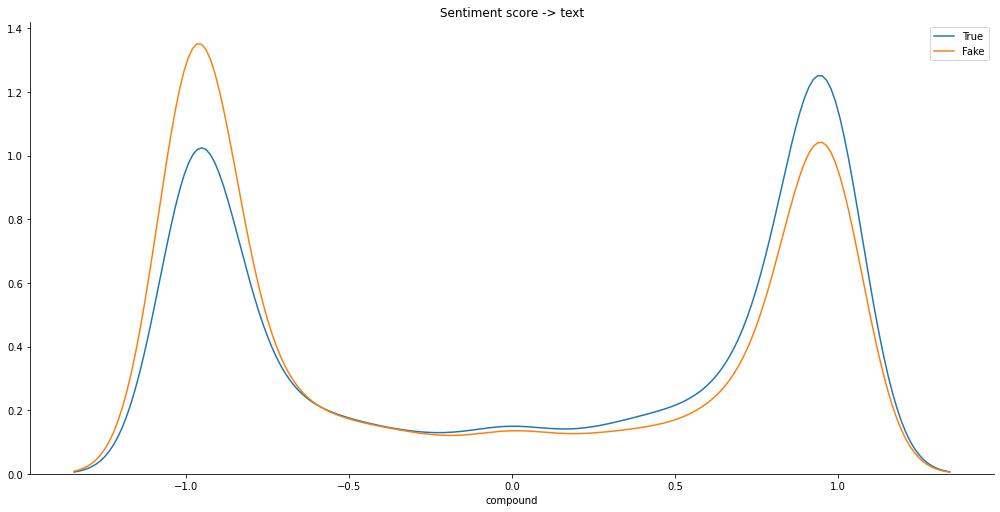

In [ ]:
# Ploting the results (text)
g = sns.FacetGrid(sia_text, hue='class', height = 7, aspect = 2)
g.map(sns.kdeplot, 'compound')
plt.title('Sentiment score -> text')
plt.legend()
plt.show()

# LDA

## Data preparation

In [ ]:
# we are going to use the gensim library to adecuate the data and perform 
# the LDA analysis

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import LdaMulticore as LDA


# We first separate each text into words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

data_words = list(sent_to_words(texts['text']))
 
print(data_words[:1][0][:15])

['epa', 'chief', 'say', 'paris', 'climate', 'agreement', 'bad', 'deal', 'united', 'state', 'continue', 'engaged', 'international', 'climate', 'change']


In [ ]:
# Dictionary
id2word = corpora.Dictionary(data_words)

# Corpus
texts_corpus = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts_corpus]

print(corpus[:1][0][:15])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 9), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 2), (14, 6)]


## Topic Modeling

In [ ]:
# Now that we have the data ready, let's build the LDA model
# We need to choose the number of topics
# To do so, we are going to compute the coherence score to determine 
# which is the optimal number of topics
# there are multiple coherence measures, we have chosen c_v, one of the most
# widely used

from gensim.models import CoherenceModel

# Let's create a function over which we can later iterate
def lda_coherence(texts_corpus, corpus, dictionary, n_topics):
    
    lda_model = LDA(corpus = corpus,
                    id2word = dictionary,
                    num_topics = n_topics, 
                    random_state=100)
    
    coherence = CoherenceModel(model = lda_model, 
                               texts = texts_corpus, 
                               dictionary = id2word, 
                               coherence = 'c_v')
    
    return coherence.get_coherence()

In [ ]:
# number of topics
num_topics = [10,20,50,80,100,120,150] # let's try to validate this number of topics

coherence_scores = []

for i in num_topics:
    coherence_scores.append(lda_coherence(texts_corpus,corpus,id2word,i))

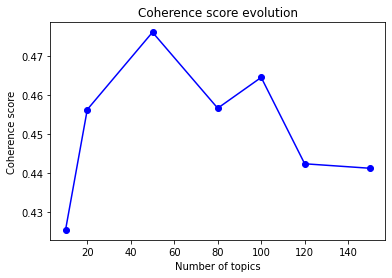

In [ ]:
# Let's plot the coherence score obtained and determine the best number of topics

plt.figure()
plt.plot(num_topics, coherence_scores, 'bo', 
         num_topics, coherence_scores, 'b')
plt.title('Coherence score evolution')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()

In [ ]:
# Therefore, the best model is with n_topics = 50

n_topics = 50

lda_final_model = LDA(corpus = corpus,
                      id2word = id2word,
                      num_topics = n_topics, 
                      random_state = 100)

In [ ]:
# Let's print the topics result

from pprint import pprint
pprint(lda_final_model.print_topics())

[(35,
  '0.015*"obama" + 0.011*"people" + 0.011*"black" + 0.008*"like" + '
  '0.008*"american" + 0.007*"president" + 0.007*"america" + 0.007*"one" + '
  '0.007*"right" + 0.006*"life"'),
 (1,
  '0.034*"trump" + 0.012*"news" + 0.009*"medium" + 0.008*"twitter" + '
  '0.008*"donald" + 0.007*"cnn" + 0.007*"president" + 0.006*"fox" + '
  '0.006*"one" + 0.006*"like"'),
 (12,
  '0.021*"law" + 0.011*"state" + 0.011*"right" + 0.010*"abortion" + '
  '0.009*"court" + 0.009*"case" + 0.007*"federal" + 0.007*"government" + '
  '0.007*"justice" + 0.006*"legal"'),
 (43,
  '0.020*"million" + 0.019*"foundation" + 0.019*"clinton" + 0.013*"money" + '
  '0.013*"fund" + 0.012*"puerto" + 0.012*"said" + 0.011*"rico" + 0.011*"drug" '
  '+ 0.008*"donation"'),
 (38,
  '0.032*"turkey" + 0.026*"said" + 0.021*"turkish" + 0.016*"erdogan" + '
  '0.010*"trial" + 0.009*"coup" + 0.008*"state" + 0.007*"ankara" + '
  '0.007*"last" + 0.007*"year"'),
 (33,
  '0.021*"woman" + 0.021*"sexual" + 0.018*"child" + 0.015*"school" + 

## Visualization

In [ ]:
pip install pyldavis

     |████████████████████████████████| 1.7MB 5.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.9MB 20.1MB/s 
     |████████████████████████████████| 15.3MB 290kB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=53e7670455b37959429293bbe744d6b9e4fdb47381a9e68f17ef06a551d1db29
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyldavis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0

In [ ]:
# We are going to make use of the pyLDAvis library to visualize the LDA results 
import pyLDAvis
from pyLDAvis import gensim_models

pyLDAvis.enable_notebook()
p = gensim_models.prepare(lda_final_model, corpus, id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
44     0.127803 -0.106668       1        1  5.734915
0     -0.029715 -0.099606       2        1  5.286779
1      0.197508 -0.030186       3        1  5.034124
16     0.041049 -0.126399       4        1  4.742348
35     0.136545 -0.009885       5        1  3.986465
18     0.031718  0.119615       6        1  3.384197
28    -0.142105 -0.047123       7        1  3.297216
47     0.068259 -0.027752       8        1  3.266668
49    -0.140004  0.114493       9        1  3.148836
41    -0.083026 -0.152072      10        1  3.118925
32    -0.115200 -0.085863      11        1  2.865059
12    -0.031189 -0.017970      12        1  2.618374
4      0.128455  0.096898      13        1  2.561207
34     0.012507 -0.130249      14        1  2.471494
39    -0.088132 -0.057923      15        1  2.449744
37    -0.143675  0.007458      16        1  2.346473
11    -0.139723  0.130535      17        1  2.226142
42    -0.088753 -0.082027      18        1  2.109541
29    -0.078155 -0.055973      19        1  2.098262
6     -0.109566  0.079294      20        1  1.943414
36    -0.124180  0.000187      21        1  1.859452
20    -0.109895  0.010311      22        1  1.849596
7     -0.119274  0.041550      23        1  1.790643
26    -0.097373 -0.038174      24        1  1.712257
2     -0.095474 -0.090328      25        1  1.656103
23     0.027892  0.103247      26        1  1.551718
30     0.081517  0.068588      27        1  1.533116
21     0.021628  0.067046      28        1  1.495614
40     0.135894  0.056524      29        1  1.482967
31    -0.100401  0.179461      30        1  1.478239
27     0.149831 -0.072903      31        1  1.435119
9      0.101292 -0.045750      32        1  1.409334
46    -0.011243 -0.111807      33        1  1.346919
33     0.127080  0.038993      34        1  1.323174
15    -0.067302  0.010575      35        1  1.301874
22     0.092340 -0.015130      36        1  1.225314
43    -0.041516 -0.038180      37        1  1.163221
14     0.153864 -0.043802      38        1  1.089176
5      0.197740  0.023288      39        1  1.063469
17     0.056941  0.075035      40        1  0.967283
10     0.127752  0.070616      41        1  0.851939
8     -0.074021  0.031831      42        1  0.739233
24    -0.007981 -0.005919      43        1  0.730970
38    -0.138597  0.062557      44        1  0.690596
45     0.036209  0.126214      45        1  0.690167
25    -0.004454  0.055652      46        1  0.683261
19    -0.028152 -0.039878      47        1  0.672943
13     0.114306  0.102642      48        1  0.583683
3      0.116624 -0.083333      49        1  0.480294
48    -0.075648 -0.057708      50        1  0.452139, topic_info=           Term           Freq          Total Category  logprob  loglift
144       trump  150041.000000  150041.000000  Default  30.0000  30.0000
884     clinton   30840.000000   30840.000000  Default  29.0000  29.0000
275  republican   41852.000000   41852.000000  Default  28.0000  28.0000
123        said  129272.000000  129272.000000  Default  27.0000  27.0000
187     twitter   14713.000000   14713.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
124         say     165.363064   29011.491955  Topic50  -5.6828   0.2316
142        time     161.533338   29616.037433  Topic50  -5.7062   0.1876
652   wednesday     144.387735   10306.876283  Topic50  -5.8184   1.1309
396        year     148.124600   42449.297811  Topic50  -5.7929  -0.2591
103       power     142.454837    9383.801512  Topic50  -5.8319   1.2112

[4212 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
5891      9  0.995589  abadi
3447      1  0.041750    abc
3447      2  0.076542    abc
3447      3  0.425622    abc
3447      4  0.062626    abc
...     ...       ...    ...
1834     16  0.001206   zuma
1834     23  0.001206   zu

# Semantic Distance

First, let's name each of the topics manually.


In [ ]:
tpc_descriptions = []

for ntpc in range(50mai):
    print(lda_final_model.show_topic(ntpc, topn=20))
    desc = input('Introduce a label for topic ' + str(ntpc) + ': ')
    tpc_descriptions.append(desc)

[('trump', 0.04299576), ('said', 0.018681703), ('president', 0.014411192), ('house', 0.013531737), ('former', 0.009484942), ('white', 0.009323702), ('campaign', 0.008799732), ('investigation', 0.008619938), ('committee', 0.0086007845), ('intelligence', 0.008045093), ('russia', 0.0077466015), ('comey', 0.0070412275), ('official', 0.007032331), ('fbi', 0.006965777), ('russian', 0.006794683), ('donald', 0.0058636633), ('director', 0.005665245), ('republican', 0.0054214736), ('election', 0.0053418097), ('flynn', 0.0048926272)]
Introduce a label for topic 0: trump
[('trump', 0.03437281), ('news', 0.012234334), ('medium', 0.009033779), ('twitter', 0.008265852), ('donald', 0.007537434), ('cnn', 0.0071674706), ('president', 0.006771201), ('fox', 0.0061089587), ('one', 0.00604383), ('like', 0.0059398697), ('time', 0.00591562), ('image', 0.0052922326), ('tweet', 0.005225155), ('video', 0.0051760413), ('people', 0.004843364), ('show', 0.0045720562), ('woman', 0.0044569066), ('fake', 0.004165448),


Secondly, we are going to compute the similatiry matrix.

In [ ]:
from gensim.matutils import corpus2csc
from scipy.sparse import triu
from ast import literal_eval
from random import sample

sample_size = 1000   # size of the sample from the corpus
corpus_size = len(corpus)  
sample_factor = sample_size / corpus_size  # factor by which we sample the corpus

mycorpus_lda = [lda_final_model[el] for el in corpus[0:sample_size]]

main_topic = [tpc_descriptions[sorted(el,key=lambda x: -x[-1])[0][0]] for el in mycorpus_lda]

Number of non-zero components in similarity matrix: 645790
We check the size of the similarity matrix: (1000, 1000)
Ratio of non-zero components: 0.64579


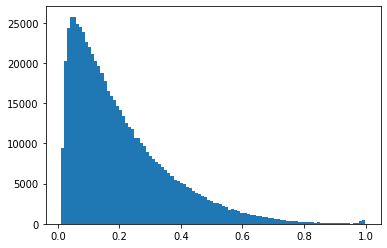

In [ ]:
# we compute the similarity matrix of the sample
X = corpus2csc(mycorpus_lda)
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)

print('Number of non-zero components in similarity matrix:', len(simmat.data))
print('We check the size of the similarity matrix:', simmat.shape)
print('Ratio of non-zero components:', len(simmat.data)/simmat.shape[0]/simmat.shape[1])

plt.hist(simmat.data, bins=100)
plt.show()

In [ ]:
thr = 0.4
simmat.data = np.where(simmat.data < thr, 0, simmat.data)
simmat.eliminate_zeros()
len(simmat.data)
print('Estimated number of links in full corpus:', len(simmat.data)/2/sample_factor**2)

Estimated number of links in full corpus: 78623433.24721202


The estimated number of links is around 77 millions. Computing the similarity matrix of the whole corpus would make google colab crash. 

# CSV files for Gephi

## Nodes

In [ ]:
# nodes csv
nodes = texts[:1000]
nodes['Label'] = main_topic
nodes.reset_index(inplace=True)
nodes = nodes.rename(columns = {'index':'Id'})

In [ ]:
nodes.head()

,Id,title,text,date,class,Media,len title,len text,Label
0,0,epa chief say paris climate agreement bad deal u,epa chief say paris climate agreement bad deal...,"April 2, 2017",True,WASHINGTON (Reuters),48,1733,obama
1,1,breaking news president trump announces major ...,breaking news president trump announces major ...,"Jul 26, 2017",Fake,Unknown,88,594,economy
2,2,trump say new hampshire win necessary secure n...,trump say new hampshire win necessary secure n...,"February 7, 2016",True,WASHINGTON (Reuters),55,1363,clinton
3,3,kremlin u sanction aimed turning business elit...,kremlin u sanction aimed turning business elit...,"November 30, 2017",True,MOSCOW (Reuters),53,394,russia
4,4,must watch kellyanne conway punch back juan wi...,must watch kellyanne conway punch back juan wi...,"Dec 27, 2016",Fake,Unknown,103,186,election


In [ ]:
# save the nodes file
path = "/path/to/nodes.csv"
nodes.to_csv(path, index = False)

## Weigths

In [ ]:
# weigths csv
simmat = triu(simmat, k=1) #Matrix is symmetric. Keep only triangular part
print('Number of links in sampled corpus:', len(simmat.data))
simmat = simmat.tocoo()

Number of links in sampled corpus: 38503


In [ ]:
path = "/path/to/edges.csv"
pd.DataFrame([el for el in zip(simmat.row.tolist(),simmat.col.tolist(),simmat.data.tolist())],
                     columns=['Source','Target','Weight']).to_csv(path, index=False)

# Fake / Real prediction

## Train - test splitting

In [ ]:
# We split into train and test and validation sets

texts_train, texts_test = train_test_split(texts, test_size = 0.25, random_state = 1)

datasets = {
    'train'        : texts_train, # 75% of the data
    'test'         : texts_test  # 25% of the data
}

for name, data in datasets.items():
    print('\n' + name + ':')
    display(pd.DataFrame(data['class'].value_counts()))


train:


,class
Fake,17708
True,15965



test:


,class
Fake,5773
True,5452


## BoW and TFIDF transformers

In [ ]:
# We transform train and test datasets for modeling
# Bag of Words and Term Frecuency Times Inverse Document frecuency 

# Train
bow_transformer = CountVectorizer(max_features = 1500).fit(texts_train['text'])
bow_train = bow_transformer.transform(texts_train['text'])

tfidf_transformer = TfidfTransformer().fit(bow_train)
train_tfidf = tfidf_transformer.transform(bow_train)

# Test
bow_test = bow_transformer.transform(texts_test['text'])
test_tfidf = tfidf_transformer.transform(bow_test)

In [ ]:
# Final train and test datasets
X_train = pd.DataFrame.sparse.from_spmatrix(train_tfidf)
X_train.columns = bow_transformer.get_feature_names()
X_test = pd.DataFrame.sparse.from_spmatrix(test_tfidf)
X_test.columns = bow_transformer.get_feature_names()

y_train = texts_train['class'].apply(lambda x: {'Fake': 1, 'True':0}[x])
y_test = texts_test['class'].apply(lambda x: {'Fake': 1, 'True':0}[x])

## Models pipeline

In [ ]:
# We define a function to evaluate the performance of the models
# - classification report
# - confusion matrix
# - accuracy

def model_evaluation(model, x_test, y_test):
  # we make the prediction
  prediction = model.predict(x_test)
  # let's print the classification report
  print(classification_report(y_test, prediction, target_names = ['True', 'Fake']))
  # let's print the confussion matrix
  display(pd.DataFrame(confusion_matrix(y_test, prediction), 
                       columns = ['True Predicted', 'Fake Predicted'],
                       index = ['True', 'Fake']))
  # accuracy
  print(f'Accuracy: {round(accuracy_score(y_test, prediction), 4)}')


# For the models that are able to show a feature importance ranking, we will apply 
# this function

def ft_ranking(model, X):
    ft = pd.DataFrame({
                'Variable'  : X.columns,
                'Importance': model.feature_importances_
            })
    ft.sort_values('Importance', ascending=False, inplace=True)
    display(ft.head(12))

From now on, we are going to apply different models to our data. We are aware that we could crossvalidate the hyperparameters of this models, but, due to the already good performance of the models and foremost to computational time, and after trying with some models, this step has been skipped. 

## Logistic Regression

In [ ]:
lg_model = LogisticRegression(
    n_jobs = -1,
    random_state = 101
)
lg_model.fit(X_train, y_train)  # we fit the model with the trainig data
model_evaluation(lg_model, X_test, y_test)  # we evaluate the model with the test data

              precision    recall  f1-score   support

        True       0.97      0.98      0.97      5452
        Fake       0.98      0.97      0.98      5773

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:295: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


,True Predicted,Fake Predicted
True,5334,118
Fake,161,5612


Accuracy: 0.9751


## Multinomial Naive Bayes Classifier

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train) # we fit the model with the trainig data
model_evaluation(nb_model, X_test, y_test) # we evaluate the model with the test data

              precision    recall  f1-score   support

        True       0.93      0.91      0.92      5452
        Fake       0.91      0.93      0.92      5773

    accuracy                           0.92     11225
   macro avg       0.92      0.92      0.92     11225
weighted avg       0.92      0.92      0.92     11225



,True Predicted,Fake Predicted
True,4940,512
Fake,390,5383


Accuracy: 0.9196


## Decision Tree Classifier

In [ ]:
dt_model = DecisionTreeClassifier(random_state = 1)
dt_model.fit(X_train, y_train) # we fit the model with the trainig data
model_evaluation(dt_model, X_test, y_test) # we evaluate the model with the test data

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:182: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)


              precision    recall  f1-score   support

        True       0.96      0.94      0.95      5452
        Fake       0.95      0.96      0.95      5773

    accuracy                           0.95     11225
   macro avg       0.95      0.95      0.95     11225
weighted avg       0.95      0.95      0.95     11225



,True Predicted,Fake Predicted
True,5135,317
Fake,213,5560


Accuracy: 0.9528


In [ ]:
# Let's print the most important features
ft_ranking(dt_model,X_test)

,Variable,Importance
1182,said,0.349062
1423,via,0.188555
1153,reuters,0.042493
1090,read,0.042258
1450,watch,0.026362
855,minister,0.025120
983,pic,0.015755
1134,representative,0.012534
567,getty,0.012383
620,hillary,0.009047


## Random Forest Classifier

In [ ]:
rf_model = RandomForestClassifier(n_jobs = -1, random_state = 1)
rf_model.fit(X_train, y_train) # we fit the model with the trainig data
model_evaluation(rf_model, X_test, y_test) # we evaluate the model with the test data

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:552: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:182: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current

              precision    recall  f1-score   support

        True       0.99      0.98      0.99      5452
        Fake       0.99      0.99      0.99      5773

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



,True Predicted,Fake Predicted
True,5369,83
Fake,68,5705


Accuracy: 0.9865


In [ ]:
# Let's print the most important features
ft_ranking(rf_model,X_test)

,Variable,Importance
1182,said,0.088311
1423,via,0.050303
493,featured,0.032751
646,image,0.028283
1153,reuters,0.023101
1427,video,0.019514
1450,watch,0.017631
855,minister,0.016556
1090,read,0.015304
267,com,0.014180


## LSTM

For this Deep Learning approach, we are going to tokenize the text. We are going to use the Keras library. 

We have, from previous analysis in this notebook, the distribution of the lengths of the texts. Based on that, we are going to keep all news lengths at 350. We add padding to those with less than 350 and we truncate those that are longer.

In [ ]:
import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout

In [ ]:
# First, we create a new tag column on the dataset:
# - Fake -> 0
# - True -> 1
texts['tag'] = texts['class'].apply(lambda x: {'Fake': 0, 'True':1}[x])

# We now split the data into train and test partitions
X_train, X_test, y_train, y_test = train_test_split(texts['text'], texts['tag'], random_state=0)

In [ ]:
# Define the constants
max_features = 9000 # maximum number of words to keep
maxlen = 350   # maximun lenght of the words
batch_size = 256 
epochs = 10
embed_size = 100

In [ ]:
# we define the tokenizer
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)   # fit on the training data

# Transform the train
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
# Transform the test
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
keras.backend.clear_session()
lstm_model = Sequential()

# Embedding layer
lstm_model.add(Embedding(max_features, 
                         output_dim=embed_size, 
                         input_length=maxlen, 
                         trainable=False))

# LSTM layers
lstm_model.add(LSTM(units=128 , 
                    return_sequences = True , 
                    recurrent_dropout = 0.25 , 
                    dropout = 0.25))

lstm_model.add(LSTM(units=64 , 
                    recurrent_dropout = 0.1 , 
                    dropout = 0.1))

# Dense layers
lstm_model.add(Dense(units = 32 , 
                     activation = 'relu'))

lstm_model.add(Dense(1, 
                     activation='sigmoid'))

# Optimizer, loss and metric used
lstm_model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Network summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
fitting = lstm_model.fit(X_train, y_train, validation_split=0.3, epochs=epochs, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 379s 4s/step - loss: 0.3444 - accuracy: 0.8478 - val_loss: 0.2522 - val_accuracy: 0.9068
Epoch 2/10
93/93 [==============================] - 379s 4s/step - loss: 0.2641 - accuracy: 0.8948 - val_loss: 0.2237 - val_accuracy: 0.9184
Epoch 3/10
93/93 [==============================] - 377s 4s/step - loss: 0.3171 - accuracy: 0.8635 - val_loss: 0.2141 - val_accuracy: 0.9204
Epoch 4/10
93/93 [==============================] - 371s 4s/step - loss: 0.2125 - accuracy: 0.9166 - val_loss: 0.1776 - val_accuracy: 0.9274
Epoch 5/10
93/93 [==============================] - 379s 4s/step - loss: 0.1663 - accuracy: 0.9361 - val_loss: 0.1367 - val_accuracy: 0.9452
Epoch 6/10
93/93 [==============================] - 375s 4s/step - loss: 0.1356 - accuracy: 0.9499 - val_loss: 0.1277 - val_accuracy: 0.9507
Epoch 7/10
93/93 [==============================] - 376s 4s/step - loss: 0.1221 - accuracy: 0.9544 - val_loss: 0.0978 - val_accuracy: 0.9629
Epoch 8/10
93

In [ ]:
print("Accuracy of the model on Training Data is - " , lstm_model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , lstm_model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 128s 121ms/step - loss: 0.0677 - accuracy: 0.9752
Accuracy of the model on Training Data is -  97.51729965209961 %
351/351 [==============================] - 42s 119ms/step - loss: 0.0874 - accuracy: 0.9684
Accuracy of the model on Testing Data is -  96.83741927146912 %


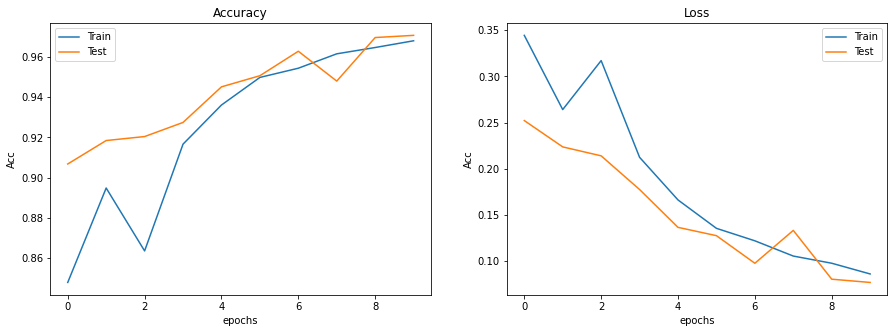

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(fitting.history["accuracy"], label = "Train")
plt.plot(fitting.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(fitting.history["loss"], label = "Train")
plt.plot(fitting.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()